## SO FAR
- it works only with ESTECO BPMM
- only elementary elements are parsed (i.e., any type of events, any type of activity, any type of gateways)
- can handle multiple process for each bpmn file
- can write the mermaid representation to a file

# TO DO
- adjust to work also with zenodo data  [need to extract node type - same as ESTECO ones. -avoid working with id as it is editor dependent]
- maybe parse additional elements?


In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import re

In [2]:
# Helper function to extract BPMN elements for a given process -- can be enriched with more elements
def extract_process_elements(ns, process):
        tasks, gateways, events, edges = [], [], [], []
        for child in process:
            # Extract all tasks
            if re.match(f'{ns}.*task', child.tag, re.IGNORECASE):    
                tasks.append(child.attrib)
            # Extract all gateways
            elif re.match(f'{ns}.*Gateway', child.tag, re.IGNORECASE):  
                gateways.append(child.attrib)
            # Extract start and end events
            elif re.match(f'{ns}.*Event', child.tag, re.IGNORECASE):
                events.append(child.attrib)
            # Extract all sequence flows (edges)
            elif child.tag == f'{ns}sequenceFlow':
                edges.append(child.attrib)
                
        return tasks, gateways, events, edges

In [3]:
def extract_bpmn_info(ns, file):
    """
    Extracts the tasks, gateways, start and end events from a BPMN file.
    
    Parameters:
    - ns: The namespace for the BPMN elements.
    - file: The BPMN file to be parsed.
    
    Returns:
    - A tuple of lists: (tasks, gateways, start_end, edges)
      Each sublist corresponds to a specific process.
    """
    # Parse the XML file
    tree = ET.parse(file)
    root = tree.getroot()

    # Extract the process elements
    processes = root.findall(f'{ns}process')

    # Check if there are multiple processes
    if len(processes) > 1:
        all_tasks = []
        all_gateways = []
        all_events = []
        all_edges = []
        
        for process in processes:
            tasks, gateways, start_end, edges = extract_process_elements(ns, process)
            all_tasks.append(tasks)
            all_gateways.append(gateways)
            all_events.append(start_end)
            all_edges.append(edges)

        print(f'Detected {len(processes)} processes in the BPMN file')
        return all_tasks, all_gateways, all_events, all_edges

    # Handle the case with a single process
    else:
        process = processes[0]
        tasks, gateways, events, edges = extract_process_elements(ns, process)
        
        print(f'Detected 1 process in the BPMN file')
        return tasks, gateways, events, edges


In [4]:
def add_name_brackets(df, tasks, gateways, events):
    """
    Add names and open/close brackets to the dataframe based on the BPMN elements.

    Parameters:
    - df: The dataframe to process.
    - tasks, gateways, events: lists.

    Returns:
    - The complete dataframe.
    """
    
    # Combine tasks, gateways, and start_end into a single dictionary with 'id' as the key and 'name' as the value
    id_to_name = {item['id']: item['name'] for item in tasks + gateways + events}

    def process_row(row):
        # Map 'sourceRef' and 'targetRef' to 'sourceName' and 'targetName'
        row['sourceName'] = id_to_name.get(row['sourceRef'], None)
        row['targetName'] = id_to_name.get(row['targetRef'], None)

        # For 'sourceRef' column (open/close symbols)
        if re.search('Events', row['sourceRef']):
            row['sourceOpen'], row['sourceClose'] = '((', '))'
        elif re.search('tasks|task|Tasks|voltaTask', row['sourceRef']):    # i think can be optimized with regex
            row['sourceOpen'], row['sourceClose'] = '[', ']'
        elif re.search('Gateways', row['sourceRef']):
            row['sourceOpen'], row['sourceClose'] = '{', '}'

        # For 'targetRef' column (open/close symbols)
        if re.search('Events', row['targetRef']):
            row['targetOpen'], row['targetClose'] = '((', '))'
        elif re.search('tasks|task|Tasks|voltaTask', row['targetRef']):
            row['targetOpen'], row['targetClose'] = '[', ']'
        elif re.search('Gateways', row['targetRef']):
            row['targetOpen'], row['targetClose'] = '{', '}'

        return row

    # Apply the combined function row-wise to the dataframe
    df = df.apply(process_row, axis=1)

    return df


In [67]:
def obtain_mer_file(ns, file, output_file, return_df=False):
    """
    Extracts the BPMN elements from a file and writes the mermaids.js file.

    Parameters:
    - ns: The namespace for the BPMN elements.
    - file: The BPMN file to be parsed.
    - output_file: The mermaids.js file to be written.
    - return_df: Whether to return the DataFrame(s) or not.

    Returns:
    - The DataFrame(s) if requested.
    """
    # Extract the BPMN elements
    tasks, gateways, events, edges = extract_bpmn_info(ns, file)

    # Ensure tasks, gateways, events, and edges are always lists
    process_count = sum(isinstance(i, list) for i in tasks) or 1    # count number of sublist in tasks, if None then # of processes = 1 else # of processes = # of sublists 
    tasks = tasks if process_count > 1 else [tasks]
    gateways = gateways if process_count > 1 else [gateways]
    events = events if process_count > 1 else [events]
    edges = edges if process_count > 1 else [edges]

    dfs = []  # List to store DataFrames for each process

    # Open the output file in write mode
    with open(output_file, 'w') as f:
        # Iterate over each process
        for i in range(process_count):
            df = pd.DataFrame(edges[i])
            df = add_name_brackets(df, tasks[i], gateways[i], events[i])
            dfs.append(df)

            # Write the formatted output for each row in the DataFrame to the file
            for _, row in df.iterrows():
                f.write(
                    f"{row['sourceRef']}{row['sourceOpen']}{row['sourceName']}{row['sourceClose']} --> | {row['name']} | {row['targetRef']}{row['targetOpen']}{row['targetName']}{row['targetClose']}\n"
                )

    # Return DataFrame(s) if requested
    if return_df:
        return dfs if process_count > 1 else dfs[0]


In [66]:
file = 'multiple_trial.bpmn'
ns = '{http://www.omg.org/spec/BPMN/20100524/MODEL}'
output_file = 'output.txt'

obtain_mer_file(ns, file, output_file)

--------------------------------------------------------------------------------------

In [79]:
file = 'multiple_trial.bpmn'
ns = '{http://www.omg.org/spec/BPMN/20100524/MODEL}'

In [80]:
dfs = obtain_mer_file(ns, file, 'output.txt', return_df=True)

Detected 2 processes in the BPMN file


In [81]:
import networkx as nx

In [83]:
G1 = nx.from_pandas_edgelist(dfs[0], 'sourceRef', 'targetRef', edge_attr=True, create_using=nx.DiGraph)
G2 = nx.from_pandas_edgelist(dfs[1], 'sourceRef', 'targetRef', edge_attr=True, create_using=nx.DiGraph)

In [86]:
nx.graph_edit_distance(G1, G2)

4.0

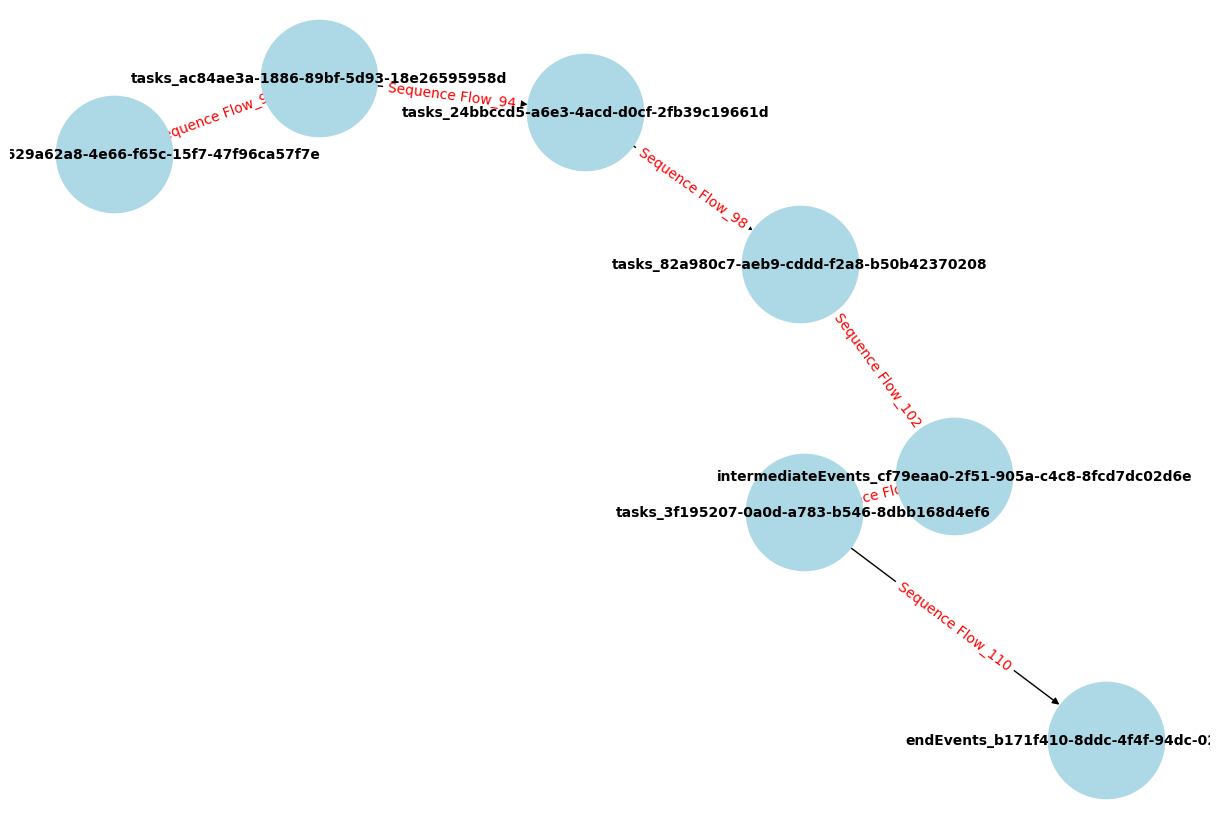

In [87]:
# Draw the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G2, seed=42)
nx.draw(G2, pos, with_labels=True, node_size=7000, node_color='lightblue', font_size=10, font_weight='bold')
edge_labels = nx.get_edge_attributes(G2, 'name')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, font_color='red')
plt.show()